In [329]:
import time
import math

def exec_time_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} 실행 시간: {end_time - start_time:.5f}초")
        return result
    return wrapper

def round_angle(angle):
    """
    각도 어림하기 (45도 간격으로 반올림)
    """
    # 기준 각도 (라디안 단위로 변환)
    predefined_angles = [0,
                            math.radians(45),
                            math.radians(90),
                            math.radians(135),
                            math.radians(180),
                            -math.radians(135),
                            -math.radians(90),
                            -math.radians(45)
                        ]

    # 각도를 -π에서 π 사이로 변환
    angle = (angle + math.pi) % (2 * math.pi) - math.pi
    
    # 가장 가까운 각도 찾기
    def adjust_angle(angle):
        # 라디안 기준으로 각도를 -π에서 π 사이로 변환
        if angle > math.pi:
            angle -= 2 * math.pi  # -π에서 π 사이로 변환
        return angle
    closest_angle = min(predefined_angles, key=lambda x: abs(adjust_angle(abs(angle - x))))
    # print(math.degrees(closest_angle))

    return closest_angle

In [330]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Literal
import math
from filterpy.monte_carlo import multinomial_resample
from filterpy.monte_carlo import residual_resample
from filterpy.monte_carlo import stratified_resample
from filterpy.monte_carlo import systematic_resample
from dtaidistance import dtw


UnitType = Literal['meter', 'coordinate']

class ParticleFilter:
    def __init__(self, m_map, gaussian_params, num_particles: int, map_constraints: np.ndarray, step_noise=0.2, gyro_noise=0.1, map_noise=0.2, plot=False, unit: UnitType = 'coordinate'):
        """
        Initialize the particle filter.
        :param gaussian_params: Dict with Gaussian parameters {'mean_x', 'mean_y', 'std_x', 'std_y'}
        :param num_particles: Number of particles.
        :param map_constraints: Spatial constraints of the map (e.g., walls, paths).
        :param gyro_noise: Standard deviation of noise added to direction changes.
        :param map_noise: Standard deviation of noise in map matching.
        """
        m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])
        self.m_map = {(row.X, row.Y): row.mag for row in m_map_df.itertuples()}
        self.gaussian_params = gaussian_params  
        self.num_particles = num_particles
        self.map_constraints = map_constraints
        self.gyro_noise = gyro_noise
        self.step_noise = step_noise
        self.map_noise = map_noise
        self.plot = plot
        self.unit = unit
        self.current_position = (0,0)
        
        self.particles = self.initialize_particles()


    @exec_time_decorator
    def initialize_particles(self):
        """
        Randomly initialize particles based on map constraints.
        """
        particles = []

        for _ in range(self.num_particles):
            while True:
                # Generate x and y from Gaussian distribution
                x = np.random.normal(self.gaussian_params['mean_x'], self.gaussian_params['std_x'])
                y = np.random.normal(self.gaussian_params['mean_y'], self.gaussian_params['std_y'])
                
                # Check if the generated coordinates are within the map constraints
                if self.map_constraints_check(x, y):
                    # print(f"({x},{y} is in map")
                    break

            # Random direction for the particle
            direction = np.arctan2(x - self.gaussian_params['mean_x'], y - self.gaussian_params['mean_y'])  # Direction in radians
            # direction = math.radians(110)
            particles.append({'x': x, 'y': y, 'direction': direction, 'weight': 1.0})

            # Initialize the particle with weight 1.0
            # particles = pd.concat([particles, new_particle], ignore_index=True)

        return pd.DataFrame(particles, columns=['x', 'y', 'direction', 'weight'])


    @exec_time_decorator
    def move_particles(self, step_length: float, step_radian: float):
        """
        Move particles based on step length and gyro data.
        """
        if self.unit == 'coordinate':
            step_length /= 0.6

        # Update direction with gyro data and noise
        # delta_direction = step_radian + np.random.normal(0, self.gyro_noise)
        # self.particles.loc[:, 'direction'] += delta_direction

        # 방식 1. step_radian을 round한 후 direction에 더하기
        self.particles['direction'] += round_angle(step_radian) + np.random.normal(0, self.gyro_noise, size=len(self.particles)) # 노이즈를 particle마다 다른 값 부여
        # Move particles in updated direction
        dx = (step_length + self.step_noise * step_length) * np.cos(self.particles.loc[:, 'direction'])
        dy = (step_length + self.step_noise * step_length) * np.sin(self.particles.loc[:, 'direction'])
        
        # 방식 2. step_radian을 direction에 더한 후 round하기
        # self.particles['direction'] += step_radian + np.random.normal(0, self.gyro_noise, size=len(self.particles)) # 노이즈를 particle마다 다른 값 부여
        # self.particles['rounded_direction'] = self.particles['direction'].apply(lambda x: round_angle(x))
        # dx = (step_length + self.step_noise * step_length) * np.cos(self.particles.loc[:, 'rounded_direction'])
        # dy = (step_length + self.step_noise * step_length) * np.sin(self.particles.loc[:, 'rounded_direction'])
        
        # 이동 거리 제한 확률 추가 <==효과 없었음
        # max_step_length = 0.5  # 최대 이동 거리
        # limit_prob = 0.8  # 이동 거리 제한 확률 (예: 80%)
        # # if np.random.rand() < limit_prob:
        
        # # 거리 계산: 원소별 연산을 위해 np.sqrt와 벡터 연산 사용
        # distance = np.sqrt(dx**2 + dy**2)

        # # 거리 제한: 벡터 연산
        # scaling_factor = np.minimum(1, max_step_length / distance)
        # dx *= scaling_factor
        # dy *= scaling_factor

        self.particles['x'] += dx
        self.particles['y'] += dy
        
        # if np.random.rand() < 0.1:  # 10% 확률로 랜덤 노이즈 추가
            # self.particles.loc[:, 'x'] += np.random.uniform(-2, 2, size=len(self.particles))
            # self.particles.loc[:, 'y'] += np.random.uniform(-2, 2, size=len(self.particles))

        def check_density_and_explore(density_threshold: float = 0.5, exploration_scale: float = 0.1):
            """
            Check if particles are densely packed and trigger exploration if necessary.
            
            Args:
                density_threshold (float): The maximum average distance below which particles are considered densely packed.
                exploration_scale (float): The scale of random exploration noise.
            """
            # Calculate pairwise distances using numpy broadcasting
            particle_positions = self.particles[['x', 'y']].to_numpy()
            pairwise_distances = np.sqrt(
                (particle_positions[:, None, 0] - particle_positions[None, :, 0])**2 +
                (particle_positions[:, None, 1] - particle_positions[None, :, 1])**2
            )
            
            # Compute the average pairwise distance
            avg_distance = np.mean(pairwise_distances)
            print(f"Average particle distance: {avg_distance}")

            # Trigger exploration if particles are too dense
            if avg_distance < density_threshold:
                print("Particles are too dense! Triggering exploration...")
                
                # Add random noise to particle positions
                self.particles['x'] += np.random.normal(0, exploration_scale, size=len(self.particles))
                self.particles['y'] += np.random.normal(0, exploration_scale, size=len(self.particles))

        check_density_and_explore(density_threshold=0.5, exploration_scale=0.5)

    # @exec_time_decorator
    # @staticmethod
    def calculate_weights_worker(self, particle, observed_vector: pd.DataFrame, step_length):
        """
        Calculate particle weights using DTW similarity.
        """

        if self.map_constraints_check(particle['x'], particle['y']) is False:
            particle['weight'] *= 1e-10
            # particle['weight'] *= 0
            # print(f"particle has reached the constraints!!!")
            # particle['weight'] *= 0.0001
            
        # elif np.sqrt((self.current_position[0] - particle['x'])**2 + (self.current_position[0] - particle['x'])**2) > step_length *2:
        #     particle['weight'] *= 1e-10
        else:
            # Simulate predicted vector (from M-Map) at particle's position
            predicted_vector = self.get_m_map_vector_(particle, step_length)  # Replace with map-based vector lookup
            
            # if 9999.9 in predicted_vector:
            #     print("9999.9 in predicted_vector")
            #     particle['weight'] *= 1e-10
            #     return particle
            
            predicted_vector = np.array(predicted_vector)
            observed_vector = observed_vector['mag'].to_numpy()
            
            # dtaidistance 사용
            distance = dtw.distance_fast(observed_vector - np.mean(observed_vector), predicted_vector - np.mean(predicted_vector))
            
            particle['dtw_distance'] = distance
            # particle['weight'] *= np.exp(- distance**2 / (2 * self.map_noise**2))
            particle['weight'] *= max(np.exp(- distance**2 / (2 * self.map_noise**2)), 1e-10)

            # print(f"particle: ({particle['x']}, {particle['y']}), distance:{distance}, weight: {particle['weight']}")
        
        return particle
    
    
    @exec_time_decorator
    def calculate_weights(self, observed_vector: pd.DataFrame, step_length):
        """
        Calculate particle weights
        """
        
        # 병렬 실행 X
        self.particles = pd.DataFrame([ self.calculate_weights_worker(
                    particle,
                    observed_vector,
                    step_length
        ) for _, particle in self.particles.iterrows()])
        
        # 병렬 실행 O
        # futures = [] 
        # with ThreadPoolExecutor() as executor:
        #     for _, particle in self.particles.iterrows():
        #         # 작업을 개별적으로 제출
        #         future = executor.submit(self.calculate_weights_worker,
        #             self,
        #             particle,
        #             observed_vector,
        #             step_length
        #         )
        #         futures.append(future)

        #     # 완료된 작업에서 결과 수집
        #     self.particles = pd.DataFrame([future.result() for future in as_completed(futures)])
        
        # self.particles.loc[:, 'weight'] += 1.e-300      # avoid round-off to zero
        self.particles.loc[:, 'weight'] /= sum(self.particles.loc[:, 'weight']) # normalize -> Posterior


    @exec_time_decorator
    def resample_particles(self):   
        """
        Resample particles based on their weights.
        """
        def resample_from_index(particles, indexes):
            # Resample particles using the given indexes
            self.particles[:] = self.particles.iloc[indexes].reset_index(drop=True)
    
            # Update weights to be uniform
            self.particles['weight'] = 1.0 / len(self.particles)
            
        def neff(weights):
            return 1. / np.sum(np.square(weights))

        N = len(self.particles)

        # resample if too few effective particles
        if neff(self.particles.loc[:, 'weight']) < N/2:
            print("resample")
            indexes = multinomial_resample(self.particles.loc[:, 'weight'])
            resample_from_index(self.particles, indexes)
        # assert np.allclose(self.particles.loc[:, 'weight'], 1/N)

    @exec_time_decorator
    def estimate_weighted_position(self):
        """
        Estimate user position based on particle distribution.
        """
        # total_weight = self.particles['weight'].sum()
        # if total_weight == 0:
        #     raise ValueError("The total weight is zero, cannot calculate weighted position.")
        # weighted_x = (self.particles['x'] * self.particles['weight']).sum() / total_weight
        # weighted_y = (self.particles['y'] * self.particles['weight']).sum() / total_weight
        
        # weight 높은 particle 200개만 사용
        count = 200
        top_df = self.particles.sort_values(['weight'], ascending=False)[:count]
        total_weight = top_df['weight'].sum()
        if total_weight == 0:
            raise ValueError("The total weight is zero, cannot calculate weighted position.")
        weighted_x = (top_df['x'] * top_df['weight']).sum() / total_weight
        weighted_y = (top_df['y'] * top_df['weight']).sum() / total_weight
        
        return weighted_x, weighted_y
    
    
    
    @exec_time_decorator
    def estimate_position(self, use_weighted_average=False, first_iter: bool = False):
        """
        Estimate user position based on particle distribution using a hybrid strategy.
        
        Args:
            use_weighted_average (bool): Flag to switch to weighted average strategy.
            
        Returns:
            tuple: (x_mean, y_mean) representing the estimated position.
        """

        if first_iter:
            return self.gaussian_params['mean_x'], self.gaussian_params['mean_y']

        if not use_weighted_average:
            # 초기 단계: 최대 가중치를 가진 입자의 위치 사용
            max_weight_particle = self.particles.loc[self.particles['weight'].idxmax()]
            return max_weight_particle['x'], max_weight_particle['y']
        else:
            # 수렴 이후: 상위 50% 가중치 입자들의 가중 평균 사용
            half_count = len(self.particles) // 2
            top_particles = self.particles.nlargest(half_count, 'weight')  # 상위 50% 선택
            total_weight = top_particles['weight'].sum()
            
            x_mean = (top_particles['x'] * top_particles['weight']).sum() / total_weight
            y_mean = (top_particles['y'] * top_particles['weight']).sum() / total_weight
            
            return x_mean, y_mean


    @exec_time_decorator
    def run_filter(self, observed_vector: pd.DataFrame, step_length, step_radian, first_iter: bool, use_weighted_average: bool):
        """ 
        Run the particle filter over a sequence of observations.
        """
        print(f"# of particle: {len(self.particles)}")
        
        positions = []

        self.move_particles(step_length, step_radian)

        self.calculate_weights(observed_vector, step_length)
        # positions.append(self.estimate_position(use_weighted_average, first_iter))
        positions.append(self.estimate_weighted_position())
        
        self.current_position = positions[-1]
        
        self.resample_particles()
        
        if self.plot:
            sampled_particle = self.particles.sample(frac=0.9, random_state=42)  # 5% 샘플링
            for particle in sampled_particle.itertuples():
                # 방향 벡터 (cos, sin)로 계산
                dx = np.cos(particle.direction)
                dy = np.sin(particle.direction)
                
                # weight에 따라 화살표 길이를 조정
                # scale_factor = max(min(particle.weight * 100, 10), 1)  # 최소, 최대 길이 보장
                scale_factor = particle.weight*100
                dx *= scale_factor
                dy *= scale_factor

                # 화살표 그리기
                # plt.scatter(particle.x, particle.y, c='grey', s=scale_factor*100, label='Particles')
                plt.arrow(
                    particle.x, particle.y, dx, dy,
                    head_width=0.1, head_length=0.1, alpha=min(scale_factor, 1),
                    fc='red', ec='red'
                )

        return positions


    # @exec_time_decorator
    def map_constraints_check(self, x: float, y: float) -> bool:
        """
        if the (x,y) impossible return false  
        """
        x_max = self.map_constraints.shape[0] - 0.5
        y_max = self.map_constraints.shape[1] - 0.5

        if (0 <= x < x_max) and (0 <= y < y_max):
            return not self.map_constraints[math.floor(x), math.floor(y)]
        else:
            return False


    # @exec_time_decorator
    def get_m_map_vector_(self, particle, step_length):
        """
        find the points from (x1, y1) to (x2, y2) 
        concat the magnitudes of points
        """
        vector = []

        dx = step_length * np.cos(particle['direction'])
        dy = step_length * np.sin(particle['direction'])

        x1 = particle['x'] - dx
        y1 = particle['y'] - dy
        
        x2 = particle['x']
        y2 = particle['y']

        
        # m_map_df = pd.DataFrame(m_map, columns=['X', 'Y', 'mag'])

        # (x1, y1)에서 (x2, y2)까지 이동하는 단계 수 계산
        # TODO: 걸음 상수 바꾸기
        # num_steps = math.dist((x1,y1),(x2,y2)) / 0.65
        num_steps = 10

        # m_map의 magnitude 값을 읽어서 벡터화
        for i in range(num_steps + 1):
            # 시작점과 끝점 사이를 보간하여 (x, y) 계산
            x = np.round(x1 + (x2 - x1) * i / num_steps, 1)
            y = np.round(y1 + (y2 - y1) * i / num_steps, 1)
            
            x = float(x) if isinstance(x, np.ndarray) else x
            y = float(y) if isinstance(y, np.ndarray) else y

            magnitude = self.m_map.get((x,y), 9999.9)

            vector.append(magnitude)

        return vector



In [331]:
import math

map_constraints = np.loadtxt('./data/obstacle_mask.txt', dtype=bool)
m_map = pd.read_csv("./data/M_map_version3.csv")

# Constraint Ploting
# print(f"M-Map Origianl Data Shape: {map_constraints.shape}")
# plt.imshow(map_constraints.T, cmap='gray', origin='lower')
# plt.title("Map Constraints (Binary Data)")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.margins(0,0)
# plt.show()

# M-MAP Ploting
# print(f"M-Map Origianl Data Shape: {m_map.shape}")
# sampled_map = m_map.sample(frac=0.1, random_state=42)  # 10% 샘플링
# obstacle_sampled_map = sampled_map[sampled_map['mag'] == 999.9]
# sampled_map = sampled_map[sampled_map['mag'] != 999.9]

# scatter = plt.scatter(sampled_map['X'], sampled_map['Y'], c=sampled_map['mag'], s=1, vmin=100, vmax=300)
# plt.scatter(obstacle_sampled_map['X'], obstacle_sampled_map['Y'], color='red', s=1)
# plt.colorbar(scatter, label="Value")
# plt.title("M Map (10% Sampling)")
# plt.xlabel("X-axis")
# plt.ylabel("Y-axis")
# plt.margins(0,0)
# plt.show()

# initial state
gaussian_params1 = {"mean_x": 92, "mean_y": 47, "std_x": 0.1, "std_y": 0.1}
gaussian_params2 = {"mean_x": 114, "mean_y": 25, "std_x": 0.1, "std_y": 0.1}
gaussian_params3 = {"mean_x": 33, "mean_y": 28, "std_x": 0.1, "std_y": 0.1}
gaussian_params4 = {"mean_x": 49, "mean_y": 52, "std_x": 0.1, "std_y": 0.1}
gaussian_params99 = {"mean_x": 7, "mean_y": 52, "std_x": 0.1, "std_y": 0.1}

# Initialize particle filter
pf = ParticleFilter(
    num_particles=1000,
    gaussian_params=gaussian_params4,
    m_map=m_map,
    map_constraints=map_constraints,
    gyro_noise=math.radians(1),
    step_noise=0.02,
    map_noise=0.7,
    plot = True,
    unit='coordinate'
)

initialize_particles 실행 시간: 0.00668초


assert that len(step_length): 60 = len(step_orientation_radians): 60
# of particle: 1000
Average particle distance: 1.2720043458036199
move_particles 실행 시간: 0.01601초
calculate_weights 실행 시간: 0.77938초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 1.33532초
[(49.97214158511526, 52.18142920908666)]


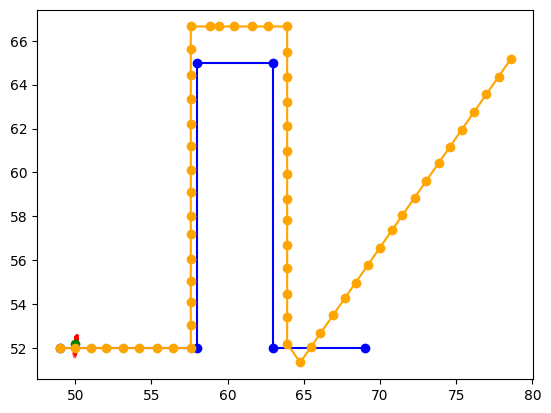

# of particle: 1000
Average particle distance: 0.5322831700809715
move_particles 실행 시간: 0.01974초
calculate_weights 실행 시간: 0.27579초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00190초
run_filter 실행 시간: 1.60016초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492)]


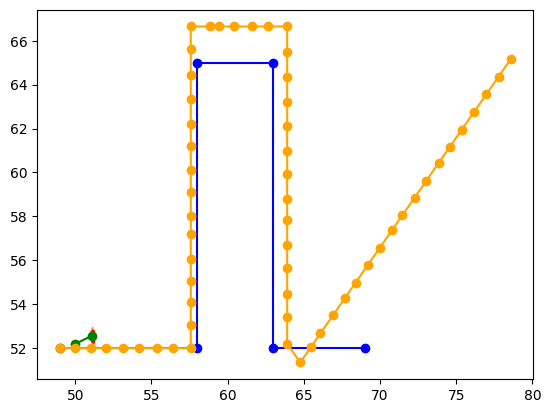

# of particle: 1000
Average particle distance: 0.16912018604534051
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.01911초
calculate_weights 실행 시간: 0.28971초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00210초
run_filter 실행 시간: 0.90611초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384)]


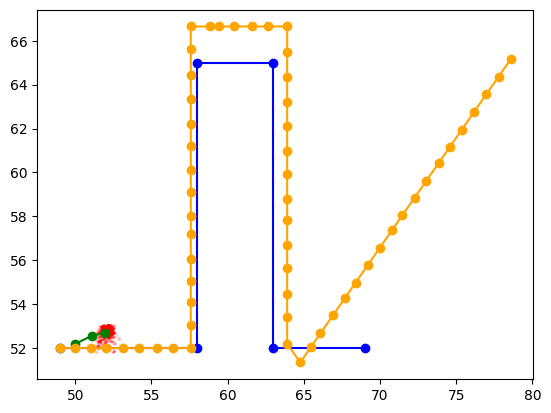

# of particle: 1000
Average particle distance: 0.4861480553106588
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02810초
calculate_weights 실행 시간: 0.23647초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.92708초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441)]


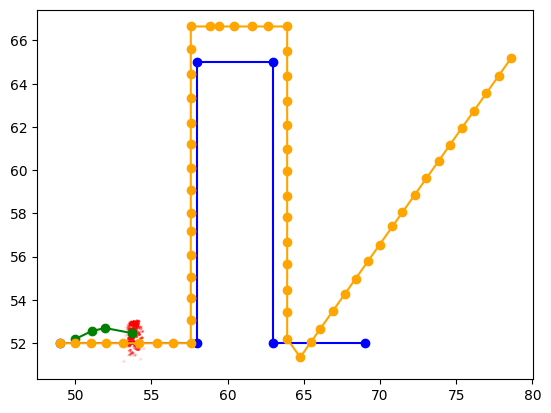

# of particle: 1000
Average particle distance: 0.5184072784783453
move_particles 실행 시간: 0.01651초
calculate_weights 실행 시간: 0.29757초
estimate_weighted_position 실행 시간: 0.00098초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.88737초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946)]


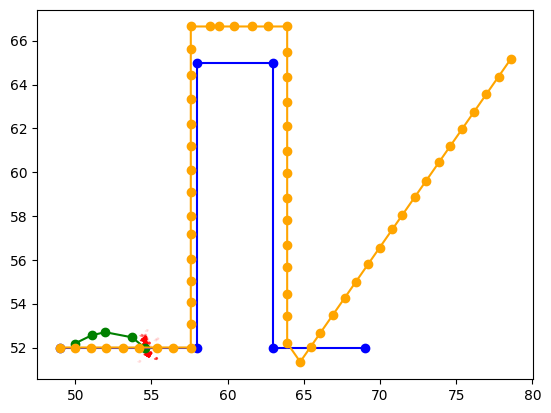

# of particle: 1000
Average particle distance: 0.40567613374463846
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.01810초
calculate_weights 실행 시간: 0.34543초
estimate_weighted_position 실행 시간: 0.00102초
resample
resample_particles 실행 시간: 0.00092초
run_filter 실행 시간: 1.43863초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316)]


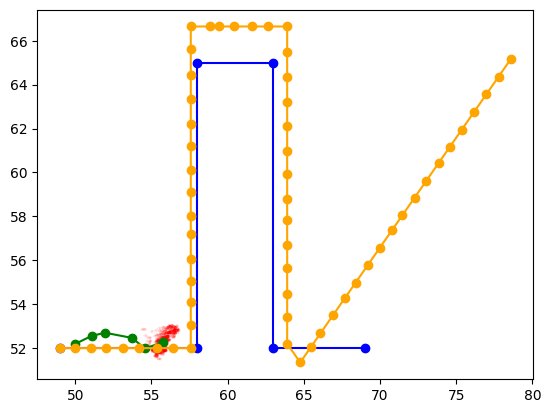

# of particle: 1000
Average particle distance: 0.6441622284990923
move_particles 실행 시간: 0.02812초
calculate_weights 실행 시간: 0.36689초
estimate_weighted_position 실행 시간: 0.00090초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.93641초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628)]


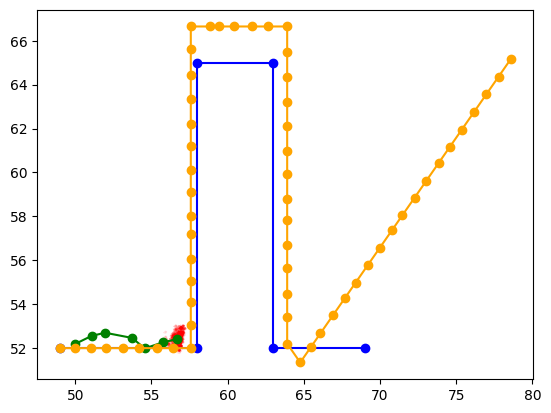

# of particle: 1000
Average particle distance: 0.42180794717044356
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.03090초
calculate_weights 실행 시간: 0.31715초
estimate_weighted_position 실행 시간: 0.00090초
resample
resample_particles 실행 시간: 0.00200초
run_filter 실행 시간: 0.85005초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374)]


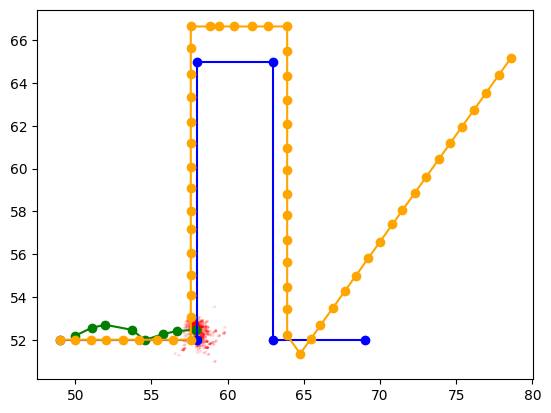

# of particle: 1000
Average particle distance: 0.6485007707619014
move_particles 실행 시간: 0.03100초
calculate_weights 실행 시간: 0.12063초
estimate_weighted_position 실행 시간: 0.00098초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 1.24277초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249)]


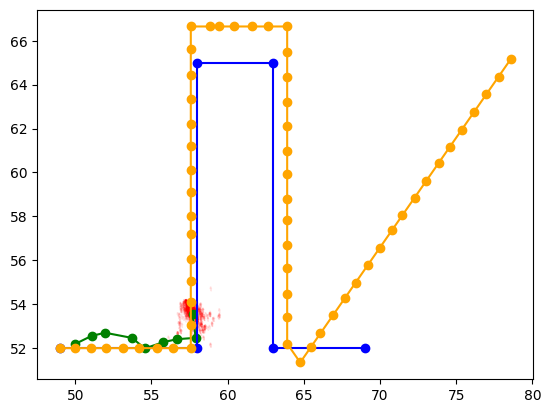

# of particle: 1000
Average particle distance: 0.6569504580385044
move_particles 실행 시간: 0.02300초
calculate_weights 실행 시간: 0.07056초
estimate_weighted_position 실행 시간: 0.00000초
resample
resample_particles 실행 시간: 0.00098초
run_filter 실행 시간: 0.61480초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484)]


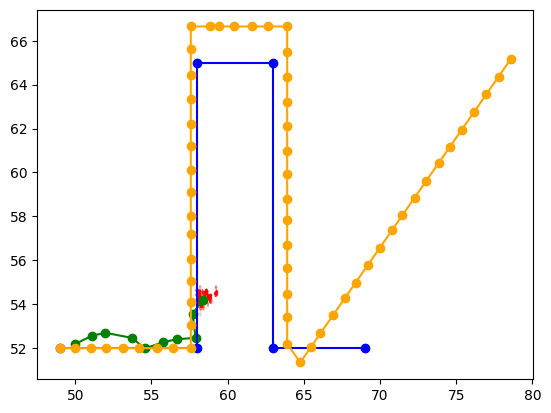

# of particle: 1000
Average particle distance: 0.4909700081424618
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02010초
calculate_weights 실행 시간: 0.25567초
estimate_weighted_position 실행 시간: 0.00102초
resample
resample_particles 실행 시간: 0.00209초
run_filter 실행 시간: 0.82615초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509)]


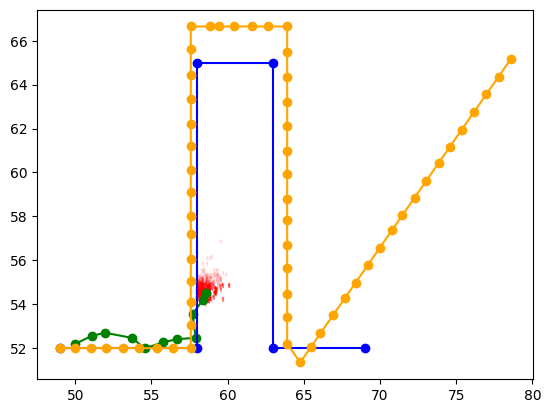

# of particle: 1000
Average particle distance: 0.6244519828835972
move_particles 실행 시간: 0.01855초
calculate_weights 실행 시간: 0.30026초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.92547초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653)]


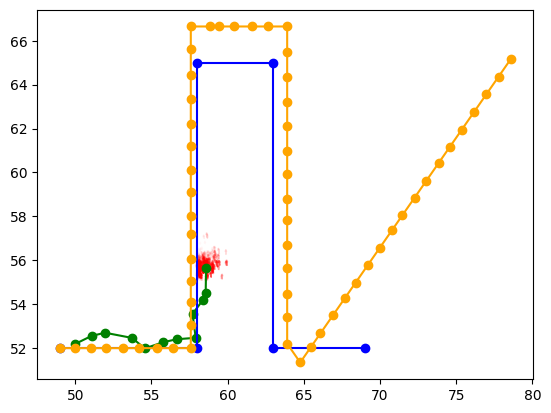

# of particle: 1000
Average particle distance: 0.6472239724767032
move_particles 실행 시간: 0.02354초
calculate_weights 실행 시간: 0.19810초
estimate_weighted_position 실행 시간: 0.00112초
resample
resample_particles 실행 시간: 0.00288초
run_filter 실행 시간: 1.48420초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148)]


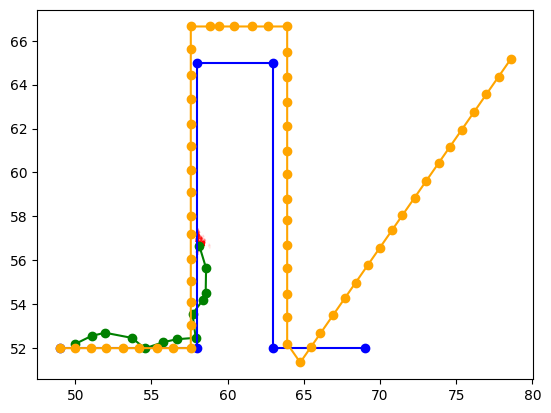

# of particle: 1000
Average particle distance: 0.20956868365062975
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02053초
calculate_weights 실행 시간: 0.17652초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00101초
run_filter 실행 시간: 0.69470초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242)]


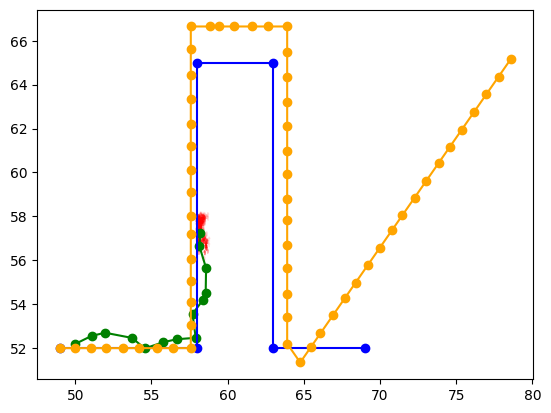

# of particle: 1000
Average particle distance: 0.5767355305153532
move_particles 실행 시간: 0.02600초
calculate_weights 실행 시간: 0.22224초
estimate_weighted_position 실행 시간: 0.00098초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.88600초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448)]


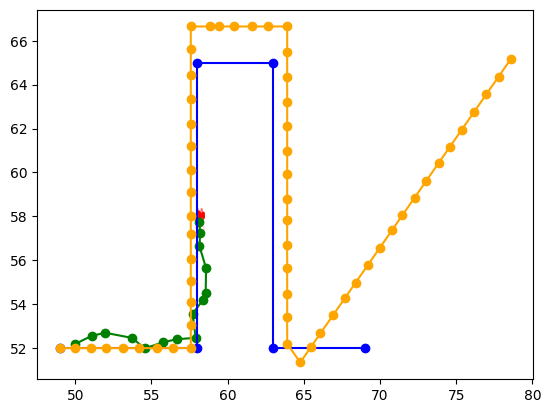

# of particle: 1000
Average particle distance: 0.315587637661677
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.01900초
calculate_weights 실행 시간: 0.21431초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.82846초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355)]


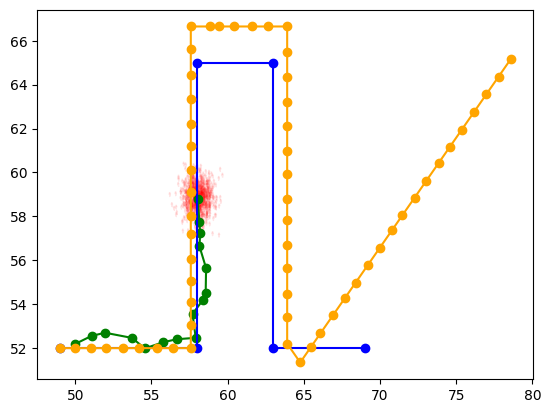

# of particle: 1000
Average particle distance: 0.9669665340679715
move_particles 실행 시간: 0.02501초
calculate_weights 실행 시간: 0.90444초
estimate_weighted_position 실행 시간: 0.00208초
resample
resample_particles 실행 시간: 0.00101초
run_filter 실행 시간: 1.44512초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967)]


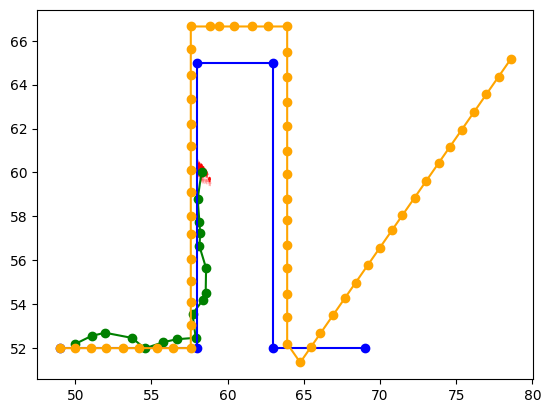

# of particle: 1000
Average particle distance: 0.28690041141246203
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02100초
calculate_weights 실행 시간: 0.25484초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00201초
run_filter 실행 시간: 0.83352초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454,

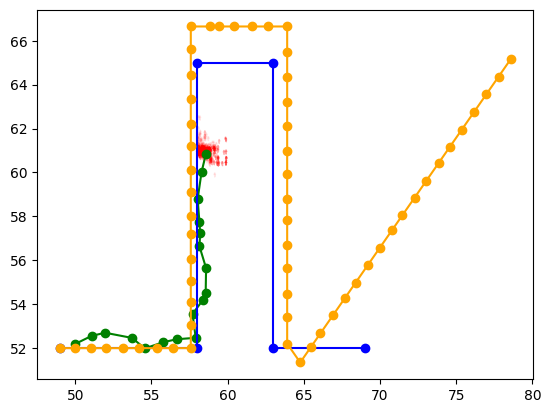

# of particle: 1000
Average particle distance: 0.5936641015080031
move_particles 실행 시간: 0.02600초
calculate_weights 실행 시간: 0.35362초
estimate_weighted_position 실행 시간: 0.00201초
resample
resample_particles 실행 시간: 0.00200초
run_filter 실행 시간: 1.01367초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

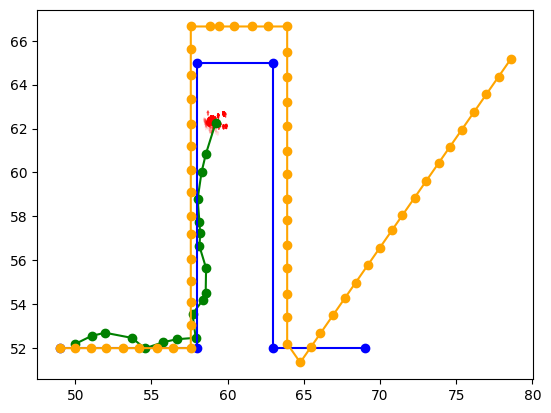

# of particle: 1000
Average particle distance: 0.5206950012528493
move_particles 실행 시간: 0.03501초
calculate_weights 실행 시간: 0.38347초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 1.74979초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

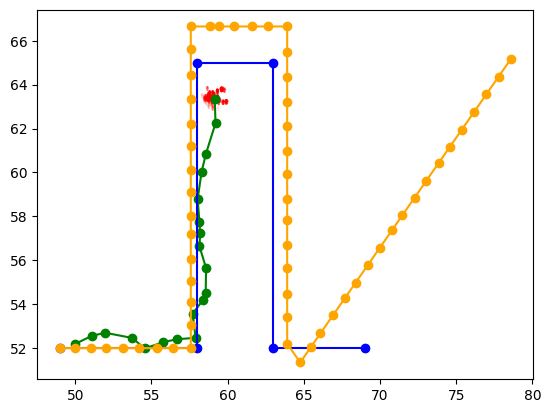

# of particle: 1000
Average particle distance: 0.5358445799002334
move_particles 실행 시간: 0.03196초
calculate_weights 실행 시간: 0.33727초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.88924초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

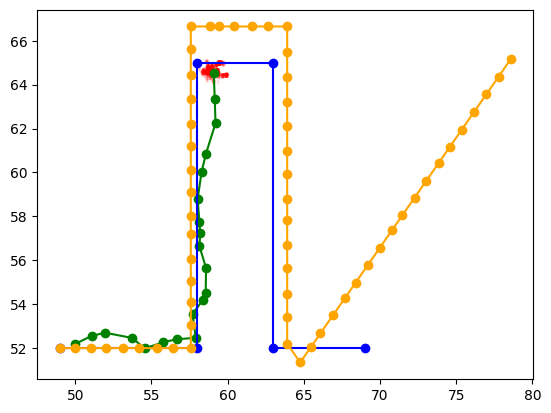

# of particle: 1000
Average particle distance: 0.5548031166492416
move_particles 실행 시간: 0.02104초
calculate_weights 실행 시간: 0.14938초
estimate_weighted_position 실행 시간: 0.00099초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.62386초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

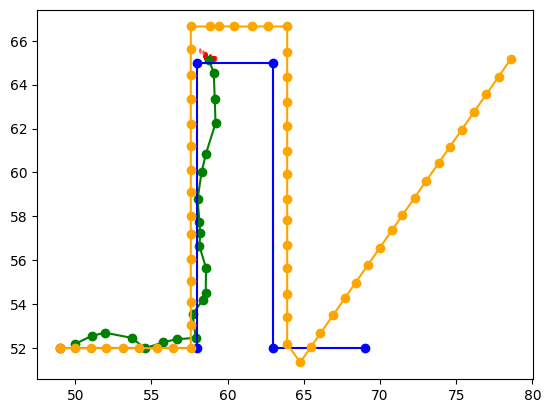

# of particle: 1000
Average particle distance: 0.2893181712386803
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.01801초
calculate_weights 실행 시간: 0.20896초
estimate_weighted_position 실행 시간: 0.00101초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.78431초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117

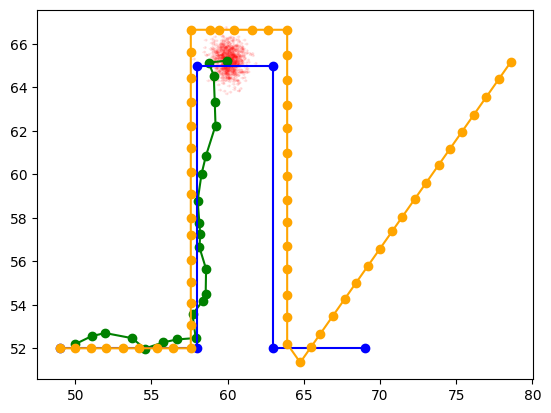

# of particle: 1000
Average particle distance: 0.9159185804393914
move_particles 실행 시간: 0.02700초
calculate_weights 실행 시간: 0.23878초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 1.48802초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

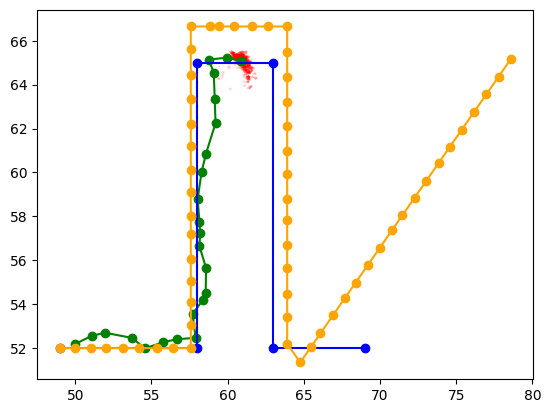

# of particle: 1000
Average particle distance: 0.5440708197546189
move_particles 실행 시간: 0.02300초
calculate_weights 실행 시간: 0.29926초
estimate_weighted_position 실행 시간: 0.00200초
resample
resample_particles 실행 시간: 0.00299초
run_filter 실행 시간: 0.85781초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

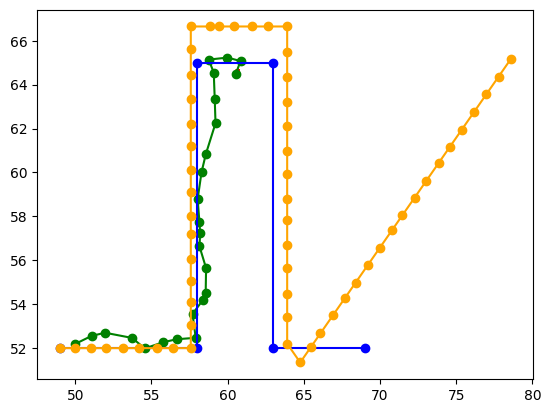

# of particle: 1000
Average particle distance: 0.07377165852680712
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.03000초
calculate_weights 실행 시간: 0.39705초
estimate_weighted_position 실행 시간: 0.00208초
resample
resample_particles 실행 시간: 0.00193초
run_filter 실행 시간: 1.02327초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454,

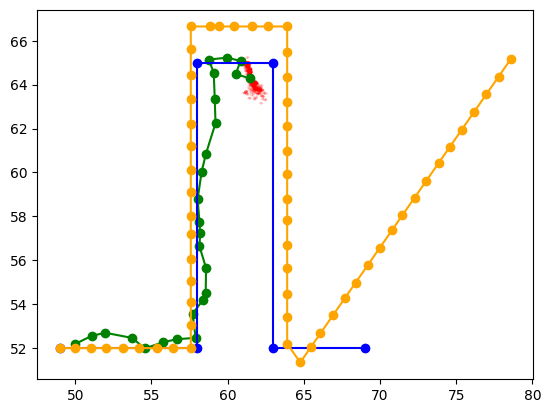

# of particle: 1000
Average particle distance: 0.6210999496874636
move_particles 실행 시간: 0.01851초
calculate_weights 실행 시간: 0.37673초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00200초
run_filter 실행 시간: 1.62582초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

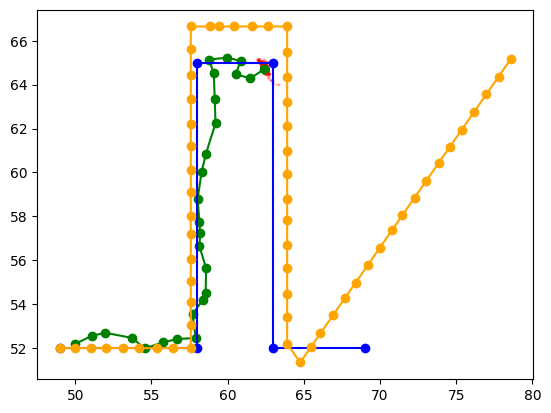

# of particle: 1000
Average particle distance: 0.2743138987228735
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.04800초
calculate_weights 실행 시간: 0.42140초
estimate_weighted_position 실행 시간: 0.00094초
resample
resample_particles 실행 시간: 0.00111초
run_filter 실행 시간: 0.96042초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 

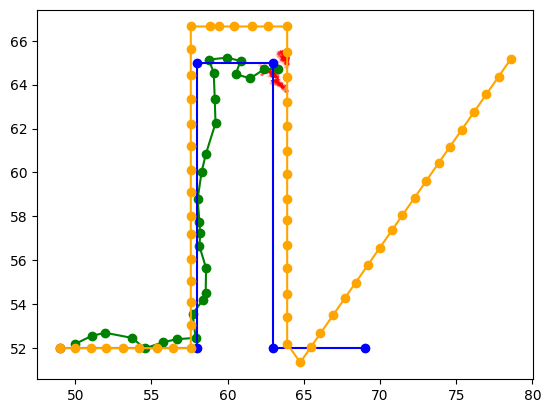

# of particle: 1000
Average particle distance: 0.8128822874331034
move_particles 실행 시간: 0.02232초
calculate_weights 실행 시간: 0.33949초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.92603초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

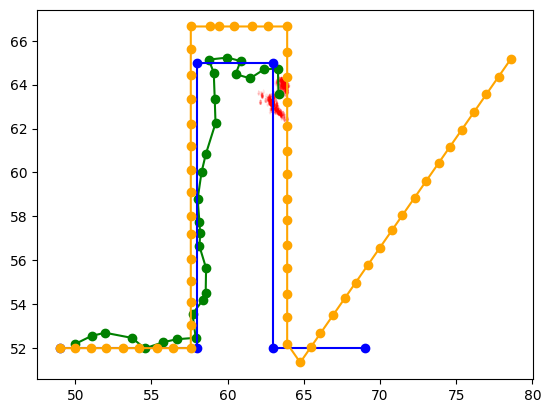

# of particle: 1000
Average particle distance: 0.8241739789132595
move_particles 실행 시간: 0.03139초
calculate_weights 실행 시간: 0.33075초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.89950초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

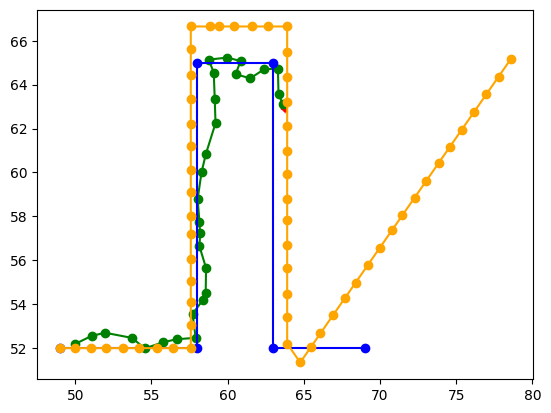

# of particle: 1000
Average particle distance: 0.13564582794368213
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02996초
calculate_weights 실행 시간: 0.28739초
estimate_weighted_position 실행 시간: 0.00199초
resample
resample_particles 실행 시간: 0.00301초
run_filter 실행 시간: 1.65830초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454,

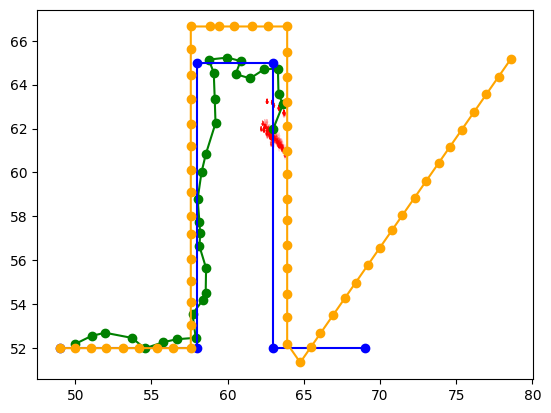

# of particle: 1000
Average particle distance: 0.9122918584432756
move_particles 실행 시간: 0.02100초
calculate_weights 실행 시간: 0.39588초
estimate_weighted_position 실행 시간: 0.00098초
resample
resample_particles 실행 시간: 0.00202초
run_filter 실행 시간: 0.99083초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

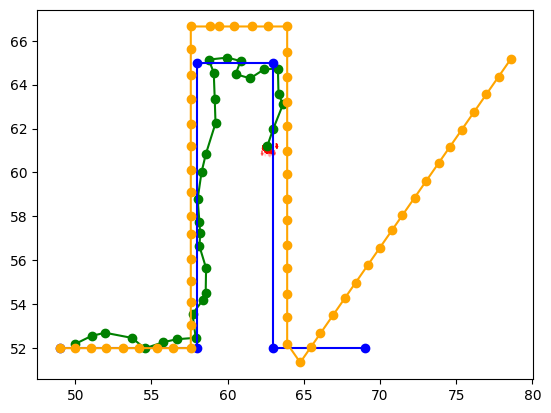

# of particle: 1000
Average particle distance: 0.24071592788926124
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02852초
calculate_weights 실행 시간: 0.32357초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.86897초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454,

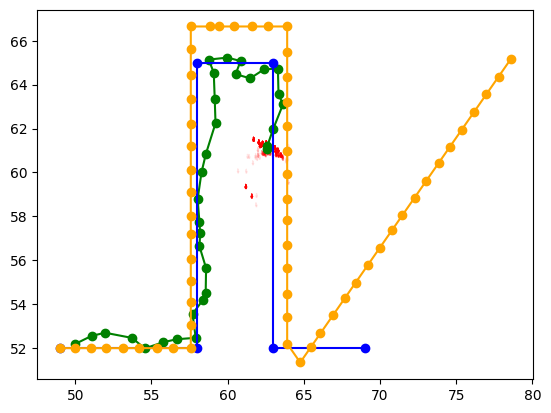

# of particle: 1000
Average particle distance: 0.9105794814010775
move_particles 실행 시간: 0.02018초
calculate_weights 실행 시간: 0.39119초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00300초
run_filter 실행 시간: 1.67066초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

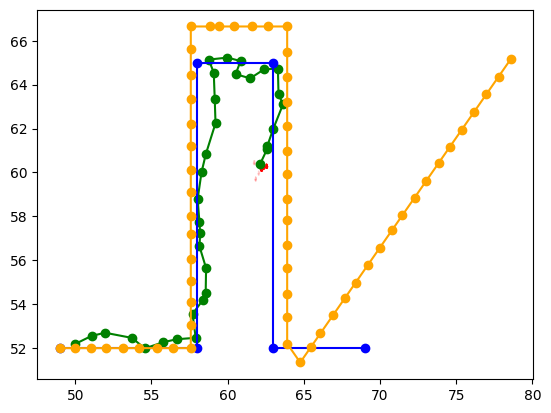

# of particle: 1000
Average particle distance: 0.17065979942266696
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02152초
calculate_weights 실행 시간: 0.36070초
estimate_weighted_position 실행 시간: 0.00099초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 1.05011초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454,

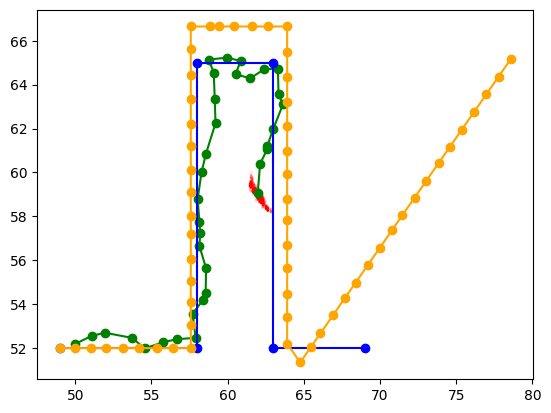

# of particle: 1000
Average particle distance: 0.5051416206733038
move_particles 실행 시간: 0.01972초
calculate_weights 실행 시간: 0.37565초
estimate_weighted_position 실행 시간: 0.00312초
resample
resample_particles 실행 시간: 0.00453초
run_filter 실행 시간: 0.99683초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

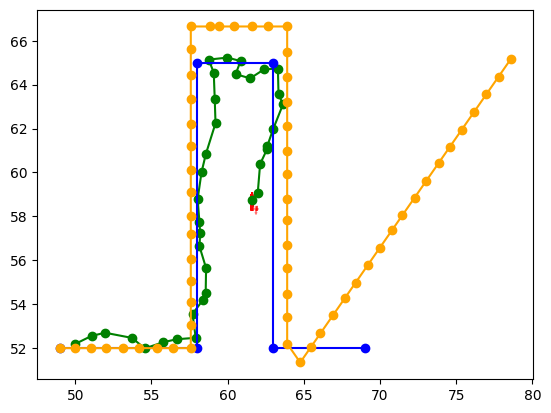

# of particle: 1000
Average particle distance: 0.259385012477785
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02431초
calculate_weights 실행 시간: 0.34051초
estimate_weighted_position 실행 시간: 0.00098초
resample
resample_particles 실행 시간: 0.00200초
run_filter 실행 시간: 0.98454초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 6

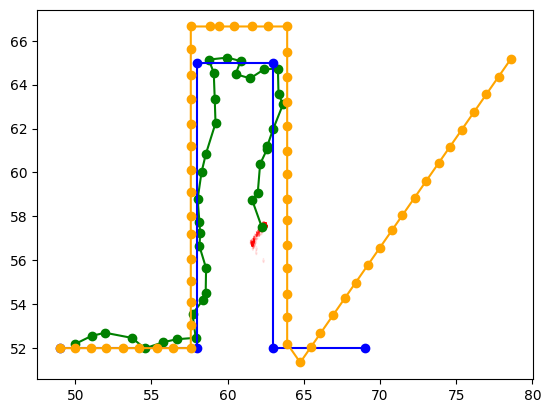

# of particle: 1000
Average particle distance: 0.3141072265860276
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.01891초
calculate_weights 실행 시간: 0.31408초
estimate_weighted_position 실행 시간: 0.00100초
resample
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 1.67990초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 

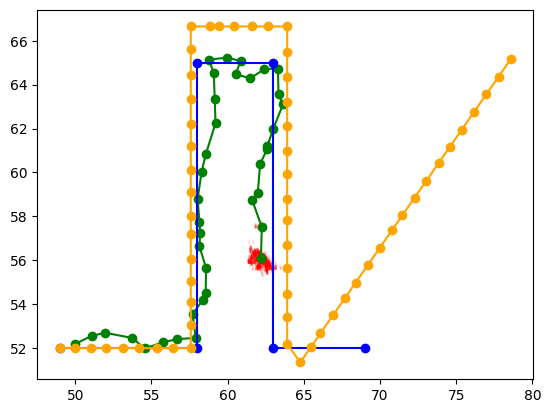

# of particle: 1000
Average particle distance: 0.6138418971763777
move_particles 실행 시간: 0.02401초
calculate_weights 실행 시간: 0.32198초
estimate_weighted_position 실행 시간: 0.00000초
resample
resample_particles 실행 시간: 0.00152초
run_filter 실행 시간: 0.81334초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

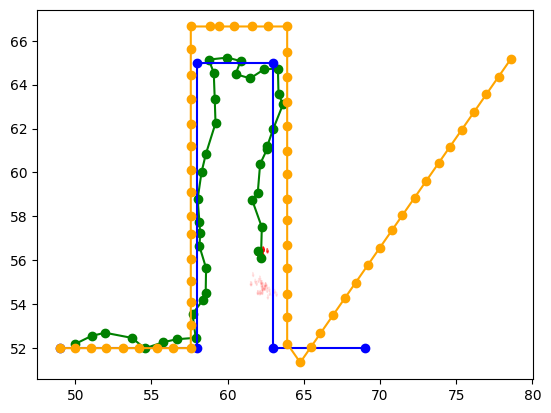

# of particle: 1000
Average particle distance: 0.229442048223219
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02799초
calculate_weights 실행 시간: 0.42960초
estimate_weighted_position 실행 시간: 0.00102초
resample
resample_particles 실행 시간: 0.00099초
run_filter 실행 시간: 1.01005초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 6

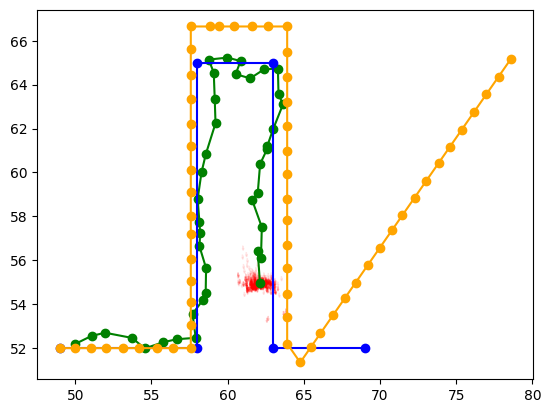

# of particle: 1000
Average particle distance: 0.6654220127149729
move_particles 실행 시간: 0.02152초
calculate_weights 실행 시간: 0.31865초
estimate_weighted_position 실행 시간: 0.00088초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 2.02517초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

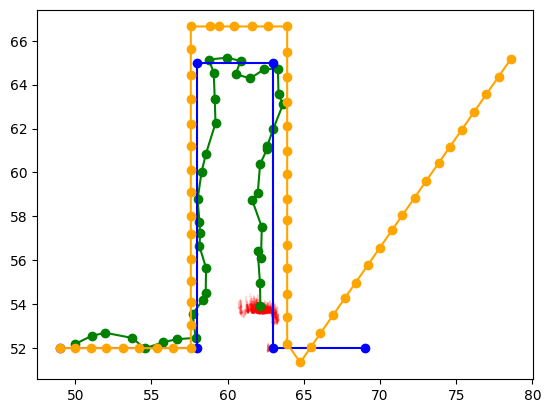

# of particle: 1000
Average particle distance: 0.6689229886549151
move_particles 실행 시간: 0.04956초
calculate_weights 실행 시간: 0.38505초
estimate_weighted_position 실행 시간: 0.00092초
resample
resample_particles 실행 시간: 0.00123초
run_filter 실행 시간: 0.97796초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.2422947

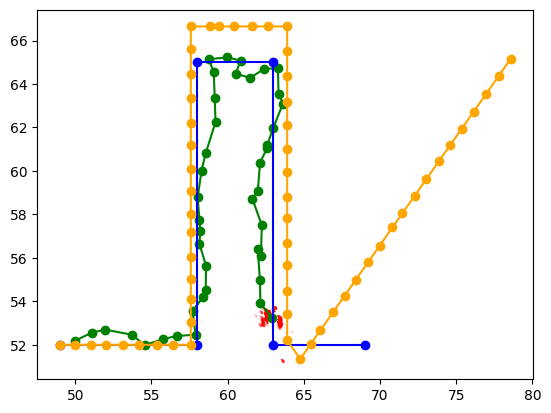

# of particle: 1000
Average particle distance: 0.671172438159656
move_particles 실행 시간: 0.02251초
calculate_weights 실행 시간: 0.28193초
estimate_weighted_position 실행 시간: 0.00129초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.87649초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155), 

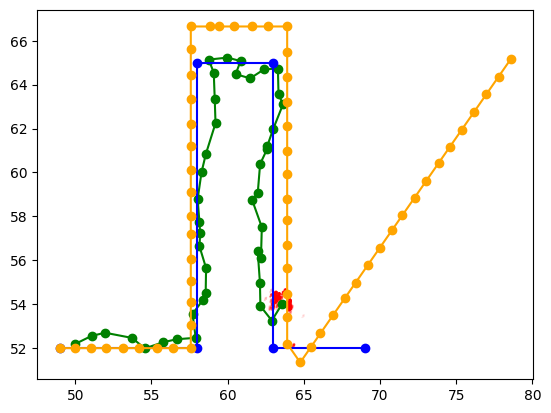

# of particle: 1000
Average particle distance: 0.679417972852144
move_particles 실행 시간: 0.02526초
calculate_weights 실행 시간: 0.18139초
estimate_weighted_position 실행 시간: 0.00103초
resample
resample_particles 실행 시간: 0.00197초
run_filter 실행 시간: 0.76627초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478

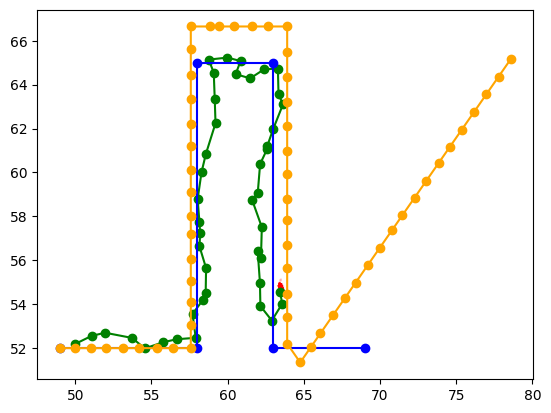

# of particle: 1000
Average particle distance: 0.21644498862591394
Particles are too dense! Triggering exploration...
move_particles 실행 시간: 0.02866초
calculate_weights 실행 시간: 0.19288초
estimate_weighted_position 실행 시간: 0.00097초
resample
resample_particles 실행 시간: 0.00105초
run_filter 실행 시간: 1.62338초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454,

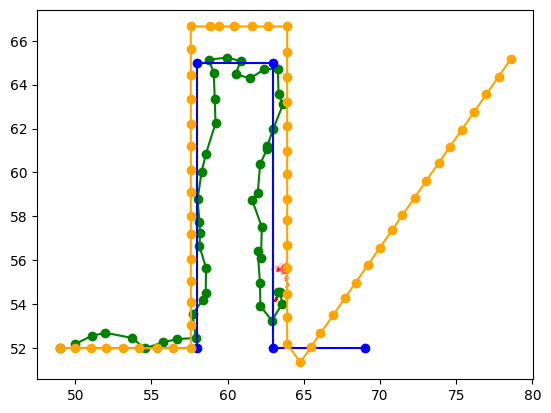

# of particle: 1000
Average particle distance: 0.61552413677956
move_particles 실행 시간: 0.02200초
calculate_weights 실행 시간: 0.35544초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.95307초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155), (

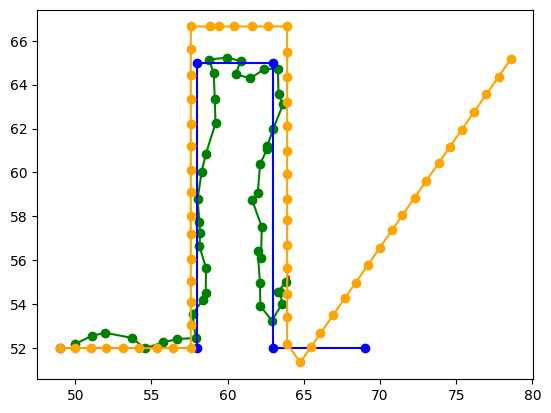

# of particle: 1000
Average particle distance: 0.6297460501513986
move_particles 실행 시간: 0.02590초
calculate_weights 실행 시간: 0.08126초
estimate_weighted_position 실행 시간: 0.00000초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.63899초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

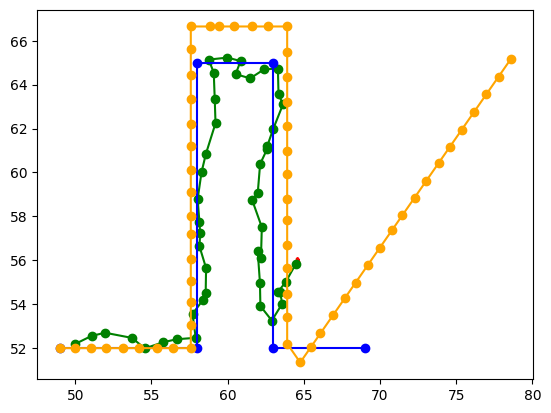

# of particle: 1000
Average particle distance: 0.6511050408939976
move_particles 실행 시간: 0.02253초
calculate_weights 실행 시간: 0.06653초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 1.44943초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

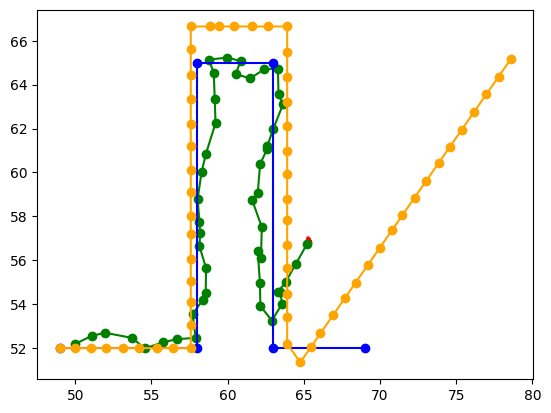

# of particle: 1000
Average particle distance: 0.674820426391611
move_particles 실행 시간: 0.02700초
calculate_weights 실행 시간: 0.10901초
estimate_weighted_position 실행 시간: 0.00096초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.78827초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155), 

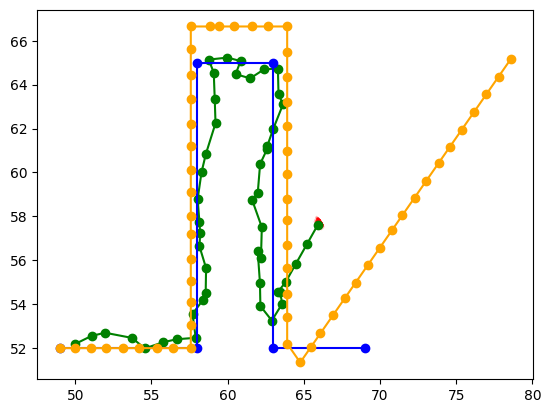

# of particle: 1000
Average particle distance: 0.7059078804324119
move_particles 실행 시간: 0.03300초
calculate_weights 실행 시간: 0.10618초
estimate_weighted_position 실행 시간: 0.00000초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.61891초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

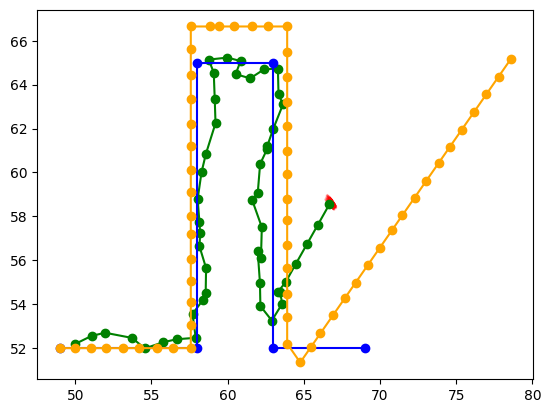

# of particle: 1000
Average particle distance: 0.7327760409330603
move_particles 실행 시간: 0.02502초
calculate_weights 실행 시간: 0.07596초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.67239초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

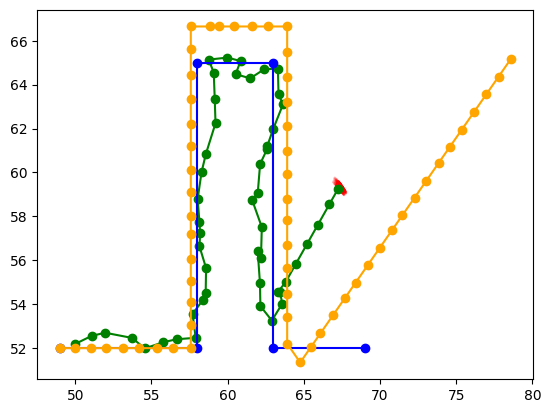

# of particle: 1000
Average particle distance: 0.7693857546609015
move_particles 실행 시간: 0.02199초
calculate_weights 실행 시간: 0.04733초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 1.29917초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

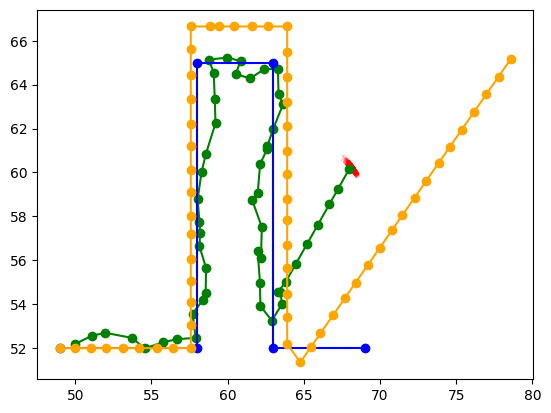

# of particle: 1000
Average particle distance: 0.8085102602559308
move_particles 실행 시간: 0.01999초
calculate_weights 실행 시간: 0.05673초
estimate_weighted_position 실행 시간: 0.00000초
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.54016초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

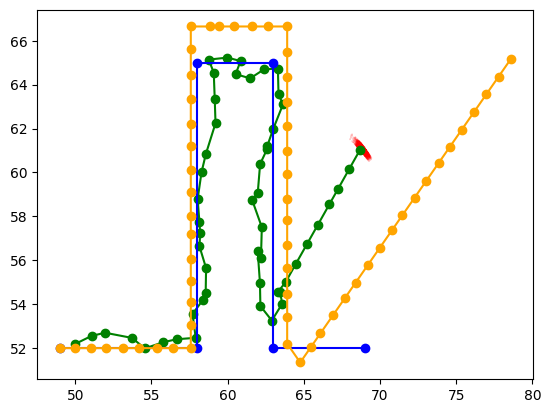

# of particle: 1000
Average particle distance: 0.8555730368674435
move_particles 실행 시간: 0.02753초
calculate_weights 실행 시간: 0.07656초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.60808초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

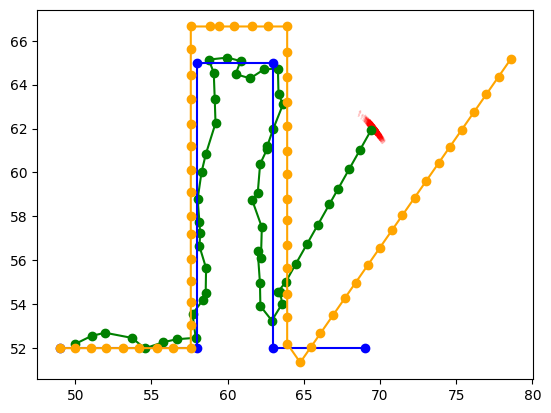

# of particle: 1000
Average particle distance: 0.8998777555960412
move_particles 실행 시간: 0.02900초
calculate_weights 실행 시간: 0.06280초
estimate_weighted_position 실행 시간: 0.00000초
resample_particles 실행 시간: 0.00100초
run_filter 실행 시간: 0.69710초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

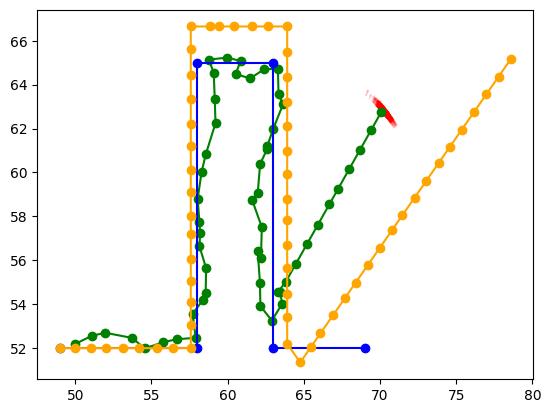

# of particle: 1000
Average particle distance: 0.9506913054697079
move_particles 실행 시간: 0.03581초
calculate_weights 실행 시간: 0.14148초
estimate_weighted_position 실행 시간: 0.00300초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.70058초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

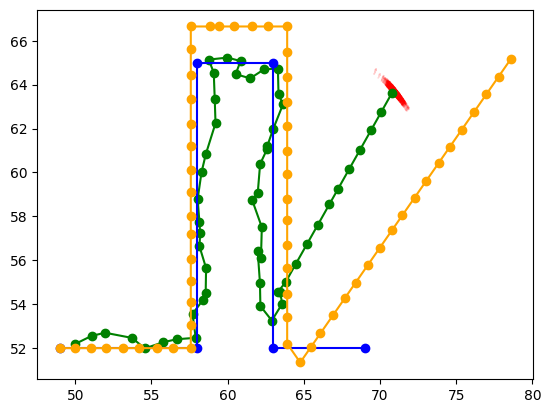

# of particle: 1000
Average particle distance: 1.00449219172498
move_particles 실행 시간: 0.02620초
calculate_weights 실행 시간: 0.04876초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.52910초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155), (

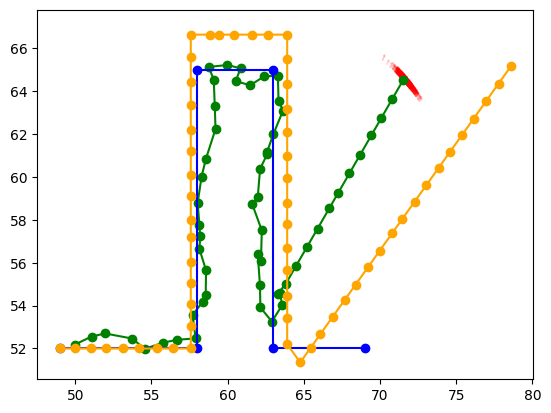

# of particle: 1000
Average particle distance: 1.064587152154032
move_particles 실행 시간: 0.01929초
calculate_weights 실행 시간: 0.05609초
estimate_weighted_position 실행 시간: 0.00109초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.57319초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155), 

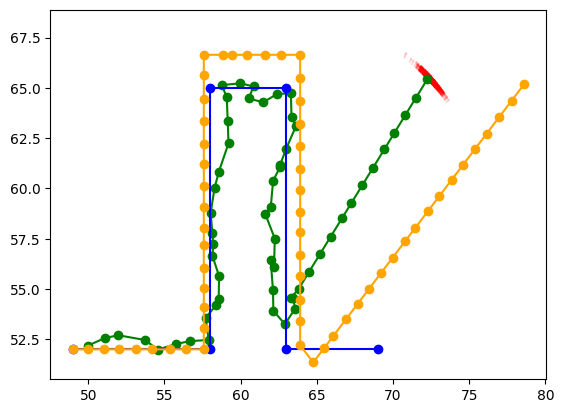

# of particle: 1000
Average particle distance: 1.12710335591676
move_particles 실행 시간: 0.05455초
calculate_weights 실행 시간: 0.15550초
estimate_weighted_position 실행 시간: 0.00100초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 1.60385초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155), (

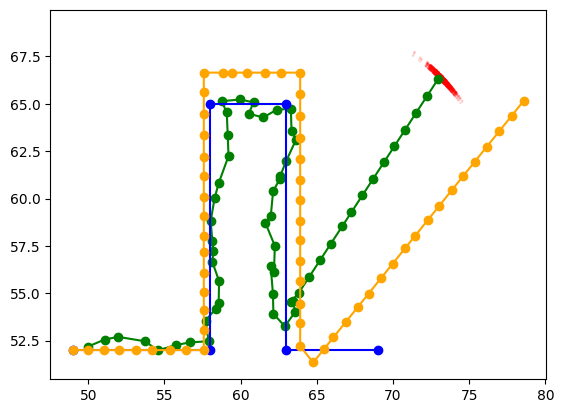

# of particle: 1000
Average particle distance: 1.1936235988623687
move_particles 실행 시간: 0.02738초
calculate_weights 실행 시간: 0.06836초
estimate_weighted_position 실행 시간: 0.00000초
resample_particles 실행 시간: 0.00000초
run_filter 실행 시간: 0.73522초
[(49.97214158511526, 52.18142920908666), (51.071504931221604, 52.55627521802492), (51.95900140246749, 52.699837530909384), (53.72834581526006, 52.46382756250441), (54.56074207321307, 51.98520574049946), (55.76421804215264, 52.268144850147316), (56.66946137829807, 52.40523850146628), (57.90392954377738, 52.468599964517374), (57.696213562114245, 53.55936445027249), (58.36770508168087, 54.18198380904484), (58.55817233803251, 54.50824754117509), (58.58509539196027, 55.6429506651653), (58.15134537372203, 56.63500622876148), (58.19725938894106, 57.237891505242), (58.144607426246054, 57.76493510910448), (58.0321167666786, 58.79157800443355), (58.28578498628896, 60.00877313739967), (58.568932276351454, 60.835117638487965), (59.20447127329618, 62.24229478471155),

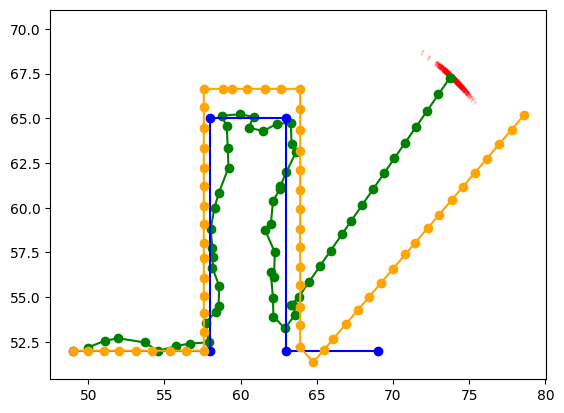

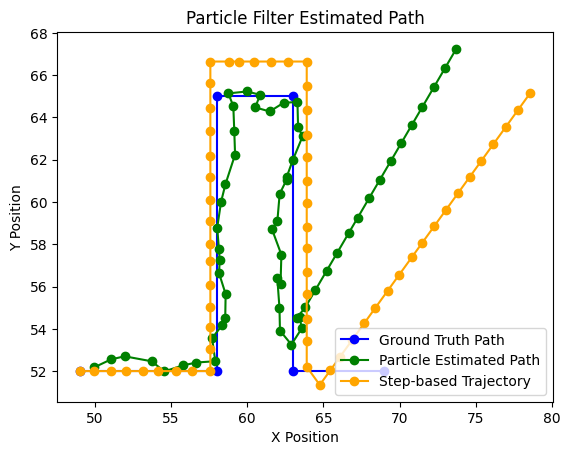

In [332]:

from step_length import *
from step_orientation import *

path_name = 'Path4'

acc_df = pd.read_csv(f"./data/{path_name}_freeOri_A31_12_05/Accelerometer.csv")
gyro_df = pd.read_csv(f"./data/{path_name}_freeOri_A31_12_05/GyroscopeUncalibrated.csv")
ori_df = pd.read_csv(f"./data/{path_name}_freeOri_A31_12_05/Orientation.csv")
mag_df = pd.read_csv(f"./data/{path_name}_freeOri_A31_12_05/MagnetometerUncalibrated.csv")
mag_df['mag'] = mag_df.apply(lambda x: math.sqrt(x['x']*x['x'] + x['y']*x['y'] + x['z']*x['z']), axis=1 )
del mag_df['x']
del mag_df['y']
del mag_df['z']

path_dict = {}
path_dict['Path1'] = pd.DataFrame([(92, 47), (102, 47), (102, 40), (92,40), (92,47)], columns=['x', 'y'])
path_dict['Path2'] = pd.DataFrame([(114, 25), (118, 25), (118, 13), (114,13), (114, 25)], columns=['x', 'y'])
path_dict['Path3'] = pd.DataFrame([(33, 28), (38, 28), (44, 22)], columns=['x', 'y'])
path_dict['Path4'] = pd.DataFrame([(49, 52), (58, 52), (58, 65), (63, 65), (63, 52), (69, 52)], columns=['x', 'y'])

step_lengths = compute_step_timestamp(
    acceleration_threshold=0.001,
    weinberg_gain=0.5,
    acce=acc_df.drop(columns=['seconds_elapsed', 'time']).to_numpy(),
    frequency=100.0
)
step_orientation_radians: list[float] = []
current_angles: list[float] = []

# Plot Ground Truth Path
ground_truth_path = path_dict[path_name]

# Tranjectory
x, y = ground_truth_path.iloc[0]  # 초기 위치
pf.current_position = (x,y)
trajectory_x = [x]
trajectory_y = [y]
trajectory_x_ori = [x]
trajectory_y_ori = [y]
current_angle = math.radians(0)  # 초기 방향 (radians)

for step in step_lengths:
    step_length = step['step_length']
    start = step['start']
    end = step['end']

    # Turning estimation
    estimated_radian = estimate_turning_angle(
        gyro_data=gyro_df.iloc[start:end, :],
        frequency=100.0
    )
    step_orientation_radians.append(estimated_radian)

    # 방향 업데이트
    current_angle += estimated_radian 
    
    current_angles.append(current_angle) 
    current_angle = round_angle(current_angle)
    
    step_length /= 0.6
    # 새로운 위치 계산
    dx = step_length * math.cos(current_angle)
    dy = step_length * math.sin(current_angle)
    x += dx
    y += dy
    trajectory_x.append(x)
    trajectory_y.append(y)
    
    dx = step_length * math.cos(round_angle(ori_df['yaw'].iloc[end]))
    dy = step_length * math.sin(round_angle(ori_df['yaw'].iloc[end]))
    trajectory_x_ori.append(trajectory_x_ori[-1] + dx)
    trajectory_y_ori.append(trajectory_y_ori[-1] + dy)
    

print(f"assert that len(step_length): {len(step_lengths)} = len(step_orientation_radians): {len(step_orientation_radians)}")

estimated_positions = []

for idx, (step_length, step_orientation_radian) in enumerate(zip(step_lengths, step_orientation_radians)):
    length = step_length['step_length']
    start = step_length['start']
    end = step_length['end']
    
    use_weighted_average = True
    if 0 <= idx < 5:
        use_weighted_average = False

    result = pf.run_filter(mag_df.iloc[start:end], length, step_orientation_radian, False, use_weighted_average)
    estimated_positions += result
    
    print(estimated_positions)
    # NumPy 배열로 변환
    positions_array = np.array(estimated_positions)
    
    # import cv2
    # floor_plan_path = 'floor_plan/KakaoTalk_20241124_152724186_02.png'  # 평면도 이미지 파일 경로
    # floor_plan = cv2.imread(floor_plan_path)
    # floor_plan = cv2.cvtColor(floor_plan, cv2.COLOR_BGR2RGB)  # OpenCV는 BGR 포맷이므로 RGB로 변환
    # plt.imshow(floor_plan, extent=(0, 153, 0, 65), origin='upper') # extent=(x_min, x_max, y_min, y_max)


    # 첫 번째 점
    if idx == 0:
        plt.plot(positions_array[0, 0], positions_array[0, 1], marker='o', color='green', label="Particle Estimated Path")
    else:
        # 이전까지의 경로
        plt.plot(positions_array[:idx+1, 0], positions_array[:idx+1, 1], marker='o', color='green', label="Particle Estimated Path")

    plt.plot(ground_truth_path['x'], ground_truth_path['y'], marker='o', color='blue', label='Ground Truth Path')
    plt.plot(trajectory_x, trajectory_y, marker='o', color='orange', label="Step-based Trajectory")
    # plt.plot(trajectory_x_ori, trajectory_y_ori, marker='o', color='Grey', label="Orientation sensor Step-based Trajectory")
    plt.show()

#Plot results
estimated_positions = np.array(estimated_positions)
estimated_positions = np.squeeze(estimated_positions)  # (n, 2)로 변환

plt.plot(ground_truth_path['x'], ground_truth_path['y'], marker='o', color='blue', label='Ground Truth Path')
plt.plot(estimated_positions[:, 0], estimated_positions[:, 1], marker='o', color='green', label="Particle Estimated Path")
plt.plot(trajectory_x, trajectory_y, marker='o', color='orange', label="Step-based Trajectory")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Particle Filter Estimated Path")
plt.show()
